# Identifying credit card frauds with classification models
##### by Tuomas Mäkäräinen (tuomas.makarainen@tuni.fi)

## Outline
    1. Introduction
        a. Brief
        c. Description
    2. Problem formulation
        a. Problem
        b. Data
        c. Libraries
        d. Inspection
    3. Method
        a. Pre-processing
        b. Models
        c. Model selection
        d. Hyperparameter tuning
    4. Results
        a. Test results
        b. Confusion matrices
    5. Conclusion
    6. References

## 1. Introduction
#### a. Brief
Credit card frauds are the kind of deception, which involves payment cards (usually credit or debit). The internet has made opened new possibilities for criminals to steal card information by hacking into databases, or by phising the information directly from the victim, for example.

#### b. Description
This notebook begins with introduction of the data. After that, the problem at hand will be formulated and the methods used will be presented. Then the training data will be fitted to the models, and the best performing model(s) will be tested with the test dataset. Finally the conclusions based on the results will be proposed.

## 2. Problem formulation
#### a. Problem
The main problem to solve here is to <b>identify fraudulent purchases</b> from historical transaction data. Because transactions are either fraudulent or non-fraudulent, the problem at hand is a <b>binary classification problem</b>. 

#### b. Data
The data used in this notebook is from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud . 

The dataset contains credit card transactions by european cardholders from September of 2013.
For confidentiality reasons most of the features  in the dataset have been transformed (V1-V28). Timestamps and the amounts of purchases haven't been altered. The binary "class"-feature implicates if the purchase was fraudulent (fraud=1, not fraud=0). This feature is highly unbalanced (0.17 % frauds, 99.83 % not frauds). There shouldn't be any missing data.

So, to classify if a transaction is fraudulent or not, the class-feature will be our target label, which will be classified with the rest of the features.

#### c. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

#### d. Inspection
First I will verify the claims about the missing data and the imbalance of the "class"-feature so let's  import the data, and inspect it.

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


No missing values, as promised. Next let's verify the distribution of the class-feature.

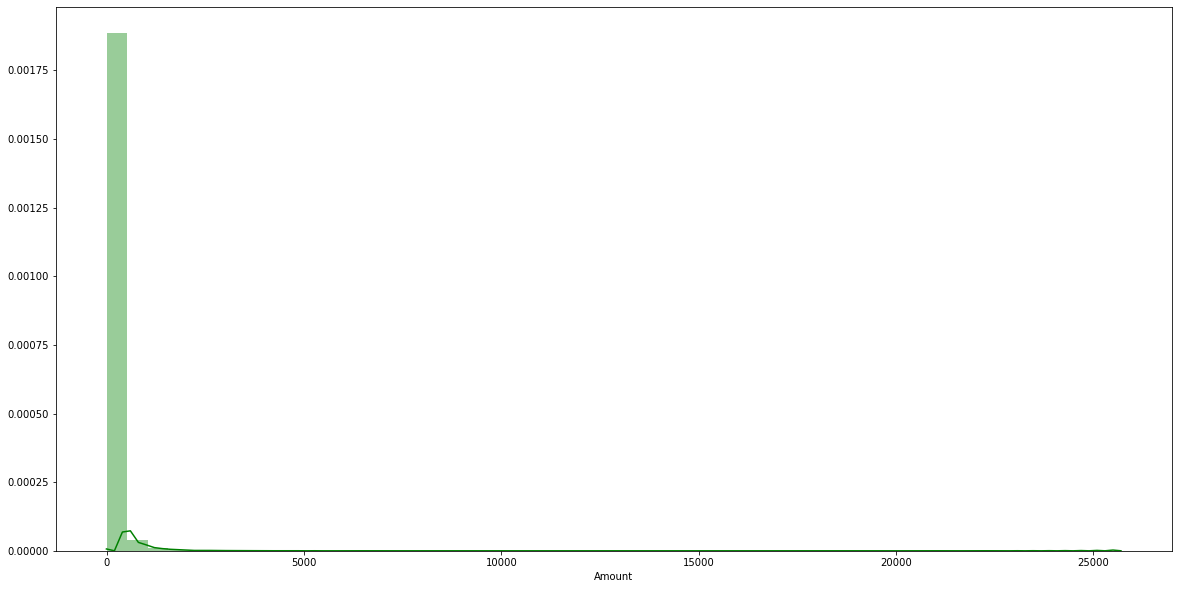

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df.Amount,ax=ax, color='g');

In [6]:
frauds_count = len(df[df.Class == 1])
nonfrauds_count = len(df[df.Class == 0])
print(f'Fraudulent purchases: {frauds_count}, which is {round(frauds_count / len(df), 4)*100}% of total data.')
print(f'Non-fraudulent purchases: {nonfrauds_count}, which is {round(nonfrauds_count / len(df), 4)*100 }% of total data.')

Fraudulent purchases: 492, which is 0.16999999999999998% of total data.
Non-fraudulent purchases: 284315, which is 99.83% of total data.


The imbalance is truly high.

## 3. Method

### a. Pre-processing
First I will try to detect and get rid of harmful outliers with a k-means clustering. Also, due to the notable imbalance, I will create a more balanced dataset by downsampling the amount of non-fraudulent transactions. After that, the unaltered features (Time, Amount) will be scaled. 

#### Outlier detection


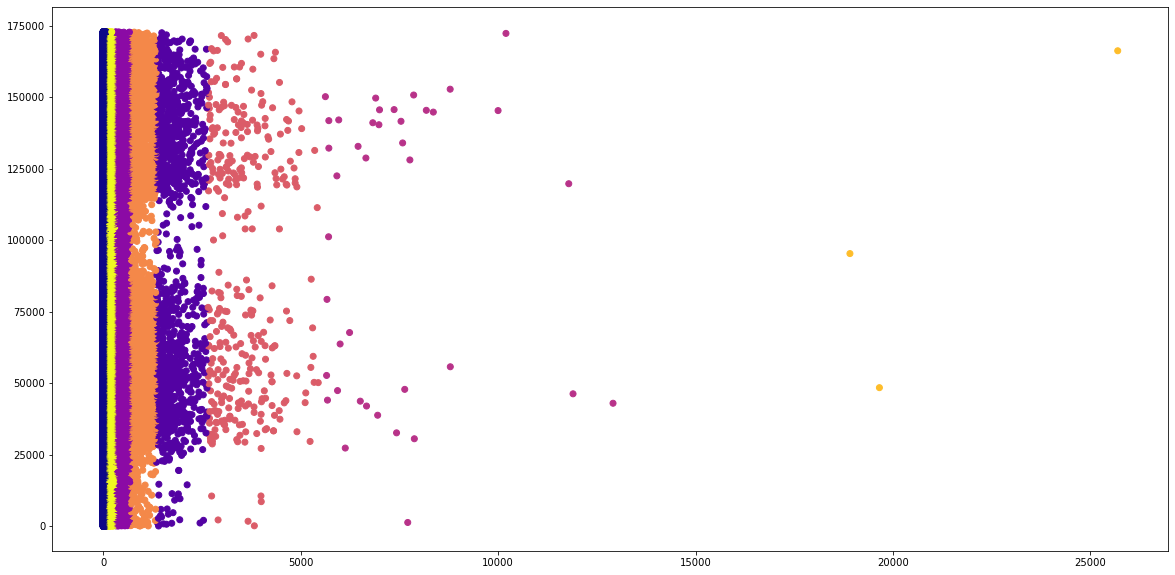

In [7]:
kmeans = KMeans(random_state=1)
kmeans.fit(df.Amount.values.reshape(-1, 1))
df['Cluster'] = kmeans.labels_
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(x=df.Amount, y=df.Time, c=df.Cluster, cmap='plasma');

Indeed, there are some outliers, which could be left out. We'll be doing that next.

0    223943
7     43094
2     11992
5      4096
1      1296
4       343
3        40
6         3
Name: Cluster, dtype: int64


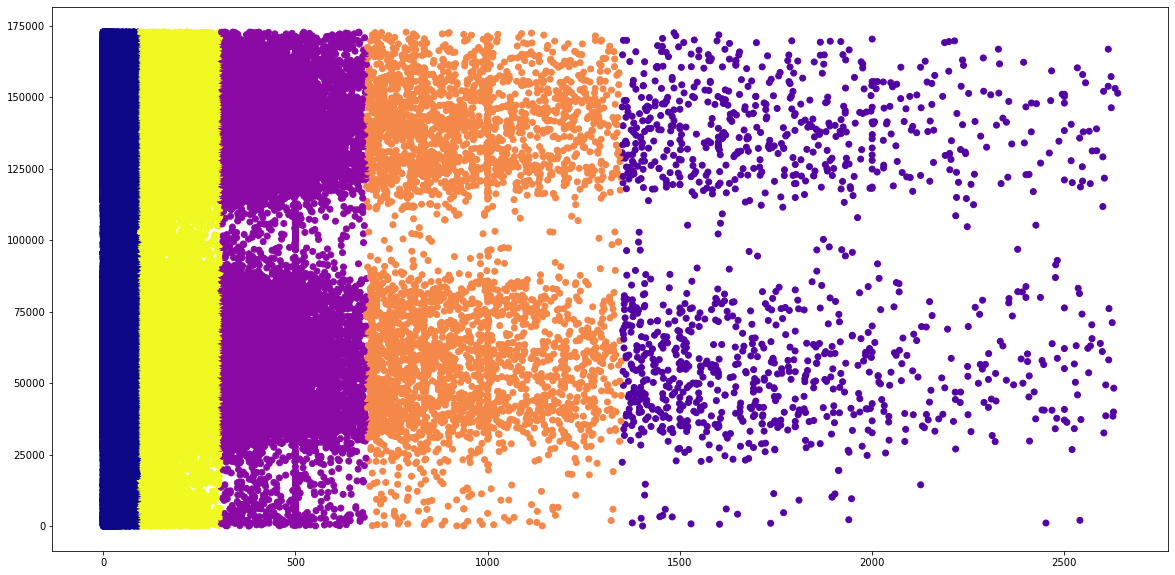

In [8]:
print(df.Cluster.value_counts())
df_clustered = df.copy()
clusters_ix = np.where( df_clustered.Cluster.value_counts() > 200 )[0].max() # Indexes of clusters with more than 1000 data points
clusters = df.Cluster.value_counts()[:clusters_ix].index.tolist()
df_clustered = df[df.Cluster.isin(clusters)]
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(x=df_clustered.Amount, y=df_clustered.Time, c=df_clustered.Cluster, cmap='plasma');

Now the data isn't as scattered as before.

#### Balancing
Now let's balance the dataset out a bit. I decided to downsample the amount of non-fraudulent transactions to match the small amount of fraudulent ones.

In [9]:
df = df_clustered.drop('Cluster', axis=1)
df = df.sample(frac=1, random_state=1)
frauds_df = df[df.Class == 1]
frauds_count = len(frauds_df)
nonfrauds_df = df[df.Class == 0][:frauds_count * 9] # Setting the amount of non-fraudulent transactions relative to the frauds
balanced_df = pd.concat([frauds_df, nonfrauds_df])

frauds_count = len(balanced_df[balanced_df.Class == 1])
nonfrauds_count = len(balanced_df[balanced_df.Class == 0])
print(f'Fraudulent purchases: {frauds_count}, which is {round(frauds_count / len(balanced_df), 4)*100}% of total data.')
print(f'Non-fraudulent purchases: {nonfrauds_count}, which is {round(nonfrauds_count / len(balanced_df), 4)*100 }% of total data.')

Fraudulent purchases: 492, which is 10.0% of total data.
Non-fraudulent purchases: 4428, which is 90.0% of total data.


Now the ratio of fraudulent and non-fraudulent transactions is much greater than originally (492/284315 -> 492/4428).

#### Scaling

In [10]:
std_scaler = StandardScaler() 
balanced_df['scaled_time'] = std_scaler.fit_transform( balanced_df.Time.values.reshape(-1, 1) )
balanced_df['scaled_amount'] = std_scaler.fit_transform( balanced_df.Amount.values.reshape(-1, 1) )
balanced_df[['Time', 'Amount', 'scaled_time', 'scaled_amount']].describe()

,Time,Amount,scaled_time,scaled_amount
count,4920.000000,4920.000000,4.920000e+03,4.920000e+03
mean,92478.340041,92.190246,-3.177224e-17,-5.776770e-18
std,47592.099210,206.711561,1.000102e+00,1.000102e+00
min,4.000000,0.000000,-1.943258e+00,-4.460303e-01
25%,52037.500000,5.207500,-8.498249e-01,-4.208356e-01
50%,82411.000000,21.945000,-2.115554e-01,-3.398571e-01
75%,137813.750000,88.292500,9.526795e-01,-1.885788e-02
max,172751.000000,2545.870000,1.686852e+00,1.187127e+01


In [11]:
balanced_df.Class.value_counts()

0    4428
1     492
Name: Class, dtype: int64

The data has now been standardized and balanced.

#### Splitting
Here I'll split the data into training and testing datasets. To do this I'll be using the Stratified KFold -method to preserve the ratio of the class-features in the datasets.

In [20]:
y =  balanced_df.Class.values
X =  balanced_df.drop(['Class', 'Time', 'Amount'], axis=1).values # Dropping the target feature, and the unscaled ones

skf = StratifiedKFold(n_splits=5)
for train_index , test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### b. Models
For the classification I'll be testing multiple models: Stochastic Gradient Descent (SGD), Support Vector, Logistic Regression, Decision Tree, and Random Forest classifiers.

In [13]:
clfs = {
    'SGD Classifier': SGDClassifier(random_state=1),
    "Support Vector Classifier": SVC(random_state=1),
    "Logisitic Regression": LogisticRegression(random_state=1),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=1),
    "Random Forest Classifier": RandomForestClassifier(random_state=1),
}

In [14]:
for key, clf in clfs.items():
    print(f'Currently working on {key}')
    clf.fit(X_train, y_train)
    print(f'Done, got accuracy score of {round(clf.score(X_train, y_train), 5)}\n')

Currently working on SGD Classifier
Done, got accuracy score of 0.97917

Currently working on Support Vector Classifier
Done, got accuracy score of 0.98374

Currently working on Logisitic Regression
Done, got accuracy score of 0.98374

Currently working on Decision Tree Classifier
Done, got accuracy score of 1.0

Currently working on Random Forest Classifier
Done, got accuracy score of 1.0



### c. Model selection
To measure the performance of the classifiers, I'll be using the F1-score, which is a harmonic mean of precision and recall scores, the ROC AUC (Area Under the Receiver Operating Characteristic Curve) -score, and confusion matrices. The model with best F1-scores will be chosen for the hyperparameter tuning. 

In [15]:
scores = {}
for key, clf in clfs.items():
    pred = clf.predict(X_test)
    scores[key] = {'F1': round(f1_score(y_test, pred), 5), 'ROC_AUC': round(roc_auc_score(y_test, pred), 5)}

scores_df = pd.DataFrame(scores).transpose()
scores_df = scores_df.sort_values(by=scores_df.columns[0], ascending=False) # Sorting the values by F1-score

best_clfs = {}
for clf in scores_df[scores_df.F1 == scores_df.F1.max()].index:
    best_clfs[clf] = {}

scores_df

,F1,ROC_AUC
Random Forest Classifier,0.95187,0.95408
SGD Classifier,0.94737,0.95806
Support Vector Classifier,0.94681,0.95352
Logisitic Regression,0.94241,0.95749
Decision Tree Classifier,0.91371,0.95410


Random Forest Classifier seems to come out on top. Let's tune it next.

### d. Hyperparameter tuning
To tune the chosen models I'll be using GridSearchCV with predefined selection of possible parameter values for each model.

In [16]:
params = {
    "SGD Classifier": {
        'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
        'penalty': ['l2'],
        'n_jobs': [-1]
    },
    "Support Vector Classifier": [
        { 'C': [0.5, 1, 1.5, 2, 2.5],
        'tol': np.logspace(-5,-1,5)},
        {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    ],
    "Logisitic Regression": {
        'C':np.logspace(-3,3,7),
        'penalty':['l1','l2'],
        'solver': ['saga'],
        'max_iter': [10000],
    },
    "Decision Tree Classifier": [{
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'class_weight': ['balanced']
    }],
    "Random Forest Classifier": [{
        'n_jobs': [-1],
        'bootstrap': [True],
        'min_samples_leaf': [3, 6, 9],
        'min_samples_split': [8, 12, 16],
        'n_estimators': [10, 100, 1000]
    }],
}

# Run the GridSearches
for clf in best_clfs:
    grid = GridSearchCV(clfs[clf], param_grid=params[clf], scoring='f1')
    grid.fit(X_train, y_train)
    best_clfs[clf] = {'F1': round(f1_score(y_test, pred), 5), 'ROC_AUC': round(roc_auc_score(y_test, pred), 5), 'Model': grid.best_estimator_}

# Show the models with highest scores
best_clfs_df = pd.DataFrame(best_clfs).transpose()
best_clfs_df.drop('Model', axis=1)

,F1,ROC_AUC
Random Forest Classifier,0.95187,0.95408


Tuning doesn't seem to have an effect on the score. This is fine, let's go the testing.

## 4. Results
In this section I'll be checking the performance of the tuned model with the test dataset.
### a. Test results

In [17]:
for key, content in best_clfs.items():
    clf = content['Model']
    print('-' * 54)
    print(key,f'\nF1: {round(f1_score(y_test, pred), 5)}, ROC_AUC: {round(roc_auc_score(y_test, pred), 5)}')
    print(classification_report(y_test, clf.predict(X_test), target_names=['Non-fraud', 'Fraud']))

------------------------------------------------------
Random Forest Classifier 
F1: 0.95187, ROC_AUC: 0.95408
              precision    recall  f1-score   support

   Non-fraud       0.99      1.00      0.99       886
       Fraud       1.00      0.91      0.95        98

    accuracy                           0.99       984
   macro avg       0.99      0.95      0.97       984
weighted avg       0.99      0.99      0.99       984



F1-scores seem good.

### b. Confusion matrices

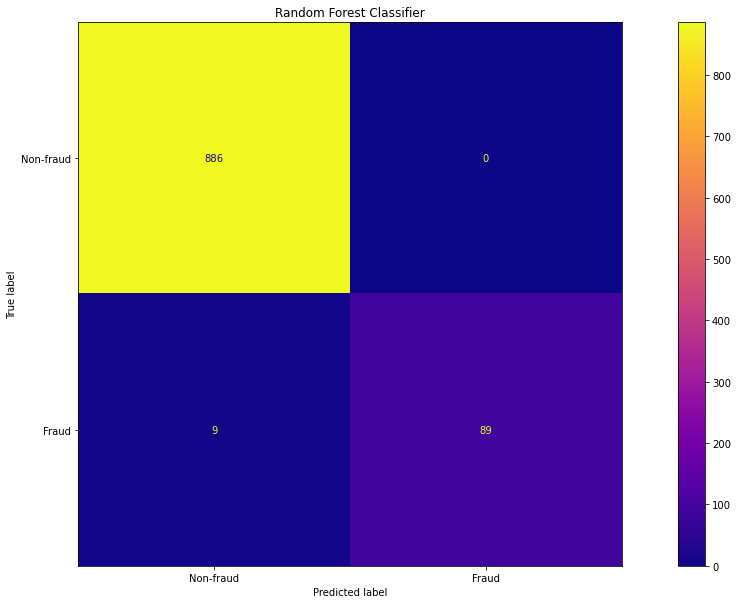

In [18]:
fig, axs = plt.subplots(1, len(best_clfs), figsize=(20, 10))
ix = 0
for key, content in best_clfs.items():
    clf = content['Model']
    if len(best_clfs) > 1:
        axs[ix].title.set_text(key)
        ax = axs[ix]
    else:
        axs.title.set_text(key)
        ax = axs
    plot_confusion_matrix(clf, X_test, y_test, cmap='plasma', display_labels=['Non-fraud', 'Fraud'], values_format='.0f', ax=ax);
    ix += 1

From this plot, it can be seen that there were 9 false negatives, and 0 false positives, and rest of the classifications were true. The 9 false negatives are frauds labelled as non-frauds, which ofcourse isn't optimal, but the amount is still relatively small compared to the correct classifications. The 0 false positives are non-fraudulent transactions labeled as fraudulent. This is good, because none of the legit customers were marked as fraudulent.

# 5. Conclusion

The results of the test dataset suggest relatively satisfactory performance. Compairing the precision and recall of my model to some of the Kaggle kernels, I believe it could be said that my models performance can compete with them. 

My main concern with my methodologies is about coping with the imbalance of the data. I believe it could be handled with smaller data loss, and I'll study more about it. Another improvement is the hyperparameter tuning, to which I'll also look more into in the future.

# 6. References
* <i>Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition</i> by Aurélien Géron
* Scikit-learn user guide and documentation